In [1]:
%reset -f
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib as mpl
from data_management import get_data
from scipy.interpolate import interp1d
from time import time
import os
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
X = get_data()
start_dates, end_dates = X.start_dates, X.end_dates
X = X.drop(['start_dates', 'end_dates'], axis=1)

JSON file loaded
Features computation launched...
n_visits = 698
Adding labels...Done!
Adding basic features...Done!
Adding bio features...Done!
Adding vital parameters features...
Done!


In [3]:
n_patients = X.patient_num.unique().shape[0]
n_visits = X.shape[0]
print("%s patients and %s stays" % (n_patients, n_visits))

285 patients and 693 stays


In [4]:
# patients coming for checkup (no crisis)
false_encounter_nums = [2008734749, 2009044366, 2009266655, 2011576945, 
                        2011622564, 2011664601, 2015724450, 2015726373]
X = X.drop(false_encounter_nums, axis=0)
n_patients = X.patient_num.unique().shape[0]
n_visits = X.shape[0]
print("%s patients and %s stays" % (n_patients, n_visits))

280 patients and 685 stays


In [5]:
print("we exclude %s stays with patients that stayed in ICU" % sum(X['Stayed in ICU'] == 1))
X = X[X['Stayed in ICU'] == 0]
X = X.drop(['Stayed in ICU'], axis=1)

n_patients = X.patient_num.unique().shape[0]
n_visits = X.shape[0]
print("%s patients and %s stays" % (n_patients, n_visits))

we exclude 64 stays with patients that stayed in ICU
259 patients and 621 stays


In [6]:
keep_GHM = (X['GHM=1'] == 1) | (X['GHM=2'] == 1)
print("we exclude %s stays with GHM=3 or 4" % (1 - keep_GHM).sum())
X = X[keep_GHM]

n_patients = X.patient_num.unique().shape[0]
n_visits = X.shape[0]
print("%s patients and %s stays" % (n_patients, n_visits))

we exclude 64 stays with GHM=3 or 4
238 patients and 557 stays


In [7]:
print("we exclude %s stays with at least 1 transfusion" % (X['Transfusion count'] > 0).sum())
X = X[X['Transfusion count'] == 0]
X = X.drop(['Transfusion count'], axis=1)

n_patients = X.patient_num.unique().shape[0]
n_visits = X.shape[0]
print("%s patients and %s stays" % (n_patients, n_visits))

we exclude 33 stays with at least 1 transfusion
232 patients and 524 stays


In [8]:
# CIM10 exclusion
CIM10_data = pd.read_csv("../data/CVO_CIM10_exclusion.csv", sep=";")
CIM10_data.index = CIM10_data.ENCOUNTER_NUM
CIM10_data = CIM10_data.drop(['ENCOUNTER_NUM'], axis=1)
CIM10_data = CIM10_data.sum(1)
enc_num_cim10 = CIM10_data.index[CIM10_data > 0]
enc_num_cim10 = enc_num_cim10.intersection(set(X.index))
X = X.drop(enc_num_cim10, axis=0)
print("%s stays excluded because of infection (CIM10)" % (n_visits - X.shape[0]))
n_patients = X.patient_num.unique().shape[0]
n_visits = X.shape[0]
print("%s patients and %s stays" % (n_patients, n_visits))

158 stays excluded because of infection (CIM10)
177 patients and 366 stays


### Duration

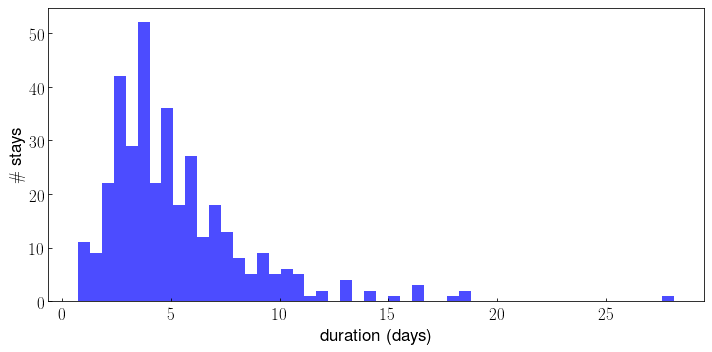

Data description:


,Length of hospital stay
count,366.000000
mean,5.261862
std,3.290534
min,0.731944
25%,3.027604
50%,4.426389
75%,6.490625
max,28.134028


In [9]:
duration = X['Length of hospital stay'] / 24

fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
pl.hist(duration, bins=50, histtype='bar', color='b', alpha = 0.7)
pl.xlabel('duration (days)', fontsize=17) , pl.ylabel(r'$\string #$ stays', fontsize=17)
ax.tick_params(axis='both', which='major', direction='in',
               labelsize=17)
pl.tight_layout()
pl.savefig('./figures/duration.pdf', bbox_inches='tight')
pl.show()
print("Data description:")
pd.DataFrame(duration).describe()

keep all stays up to the 90-th percentile of stays duration (9.2 days)
37 stays deleted


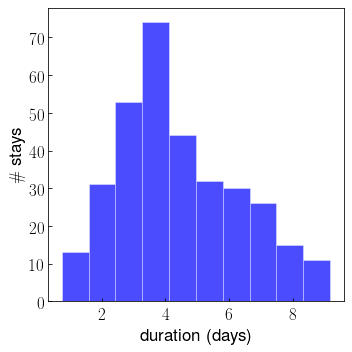

(329, 72)

In [10]:
q = 90
p = np.percentile(duration, q)
print("keep all stays up to the %s-th percentile of stays duration (%.1f days)" % (q, p))
delete = duration > p
print("%s stays deleted" % sum(delete))
X = X[~delete]

# new duration times
duration = X['Length of hospital stay'] / 24

fig = pl.figure(figsize=(5,5))
ax = fig.add_subplot(111)
pl.hist(duration, bins=10, histtype='bar', 
        color='b', alpha = 0.7,
        edgecolor='white', linewidth=.5)
pl.xlabel('duration (days)', fontsize=17) , pl.ylabel(r'$\string #$ stays', fontsize=17)
ax.tick_params(axis='both', which='major', direction='in',
               labelsize=17)
pl.tight_layout()
pl.savefig('./figures/duration2.pdf', bbox_inches='tight')
pl.show()

X = X.drop(['Length of hospital stay'], axis=1)
X.shape

In [11]:
n_patients = X.patient_num.unique().shape[0]
n_visits = X.shape[0]
print("%s patients and %s stays" % (n_patients, n_visits))

patient_num = X.patient_num
X = X.drop(['patient_num'], axis=1)

164 patients and 329 stays


Censoring level with all stays: 37.7%


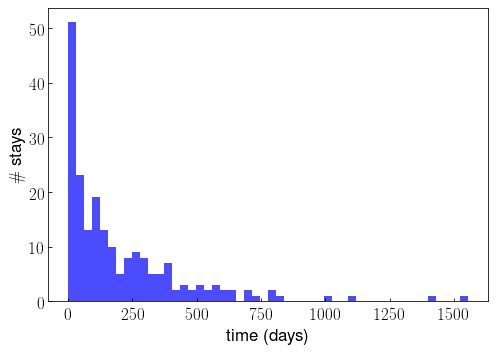

Data description:


,Y
count,205.000000
mean,203.573984
std,244.624688
min,0.750000
25%,33.125000
50%,123.000000
75%,286.125000
max,1553.166667


In [12]:
Y, delta = X.Y, X.delta
X = X.drop(['Y', 'delta'], axis=1)
Y /= 24 # in days
T = Y[delta == 1]
print("Censoring level with all stays: %.1f%%" % (np.sum(1-delta) / len(delta) * 100))

fig = pl.figure(figsize=(7,5))
ax = fig.add_subplot(111)
pl.hist(T, bins=50, histtype='bar', color='b', alpha = 0.7)
pl.xlabel('time (days)', fontsize=17) , pl.ylabel(r'$\string #$ stays', fontsize=17)
ax.tick_params(axis='both', which='major', direction='in',
               labelsize=17)
pl.tight_layout()
pl.savefig('./figures/times_between_visits.pdf', bbox_inches='tight')
pl.show()
print("Data description:")
pd.DataFrame(T).describe()

### Nb of visits per patient

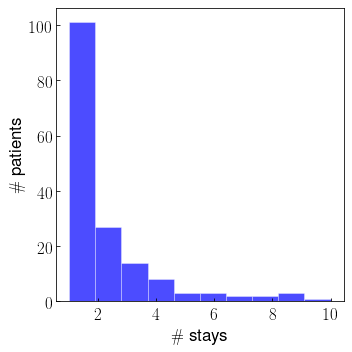

Data description:


,patient_num
count,164.000000
mean,2.006098
std,1.845229
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,10.000000


In [13]:
nb_visits_per_patient = patient_num.value_counts()

fig = pl.figure(figsize=(5,5))
ax = fig.add_subplot(111)
pl.hist(nb_visits_per_patient, bins=10, 
        histtype='bar', color='b', alpha = 0.7,
        edgecolor='white', linewidth=.5)
pl.xlabel(r'$\string #$ stays', fontsize=17) , pl.ylabel(r'$\string #$ patients', fontsize=17)
ax.tick_params(axis='both', which='major', direction='in',
               labelsize=17)
pl.tight_layout()
pl.savefig('./figures/nb_visits_per_patient.pdf', bbox_inches='tight')
pl.show()
print("Data description:")
pd.DataFrame(nb_visits_per_patient).describe()

### Number of points per covariates

In [14]:
pd.set_option('display.max_rows', 150)
columns = ['Covariate', 'At least 1 point (%)', 'Mean (sd)', 
           'Median (Q1 ; Q3)', 'Min ; Max']
df = pd.DataFrame(columns=columns)
n_visits = X.shape[0]
for col in X.columns:
    nb_nan = X[col].isnull().sum()    
    tmp = [(0 if type(val) == np.float else len(val) - (val).isnull().sum()) 
           if type(val) == pd.Series
           else (0 if np.isnan(val) else 1)
           for val in X[col]] 
    df = df.append(pd.DataFrame([[col, 
                                  "%.1f" % (100*(n_visits-nb_nan)/n_visits),
                                  "%.1f (%.1f)" % (np.mean(tmp), np.std(tmp)), 
                                  "%d (%d ; %d)" % (np.percentile(tmp, 50),
                                                          np.percentile(tmp, 25), 
                                                          np.percentile(tmp, 75)), 
                                  "%d ; %d" % (np.min(tmp), np.max(tmp))]], 
                                columns=columns))
df.index = df["Covariate"]
df = df.drop(['Covariate'], axis=1)
df

,At least 1 point (%),Mean (sd),Median (Q1 ; Q3),Min ; Max
Covariate,,,,
Household situation,76.9,0.8 (0.4),1 (1 ; 1),0 ; 1
Professional activity,86.6,0.9 (0.3),1 (1 ; 1),0 ; 1
History of acute chest syndrom,100.0,1.0 (0.0),1 (1 ; 1),1 ; 1
History of avascular bone necrosis,100.0,1.0 (0.0),1 (1 ; 1),1 ; 1
Formerly or currently on a dialysis protocol,100.0,1.0 (0.0),1 (1 ; 1),1 ; 1
History of heart failure,100.0,1.0 (0.0),1 (1 ; 1),1 ; 1
History of ischemic stroke,100.0,1.0 (0.0),1 (1 ; 1),1 ; 1
History of leg skin ulceration,100.0,1.0 (0.0),1 (1 ; 1),1 ; 1
History of known nephropathy,100.0,1.0 (0.0),1 (1 ; 1),1 ; 1


### basic features description

In [15]:
pd.set_option('display.max_columns', 100)
basic_features = X.describe().columns
X.describe()

,Household situation,Professional activity,History of acute chest syndrom,History of avascular bone necrosis,Formerly or currently on a dialysis protocol,History of heart failure,History of ischemic stroke,History of leg skin ulceration,History of known nephropathy,History of pulmonary hypertension,History of priapism*,History of known retinopathy,Received orally administered opioids,Received Morphine,Received Oxycodone,Age at hospital admission,Baseline haemoglobin ($g/dL$),Genotype,Gender,GHM=1,GHM=2,GHM=3,GHM=4,dist,drive
count,253.000000,285.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,275.000000,275.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.0,329.0,324.000000,324.000000
mean,0.241107,0.140351,0.753799,0.252280,0.006079,0.003040,0.021277,0.069909,0.039514,0.063830,0.094225,0.121581,0.042553,0.989091,0.025455,29.854062,8.861398,0.705167,0.495441,0.796353,0.203647,0.0,0.0,21.085231,26.559053
std,0.428603,0.347962,0.431453,0.434982,0.077849,0.055132,0.144525,0.255382,0.195110,0.244822,0.292586,0.327299,0.202155,0.104065,0.157788,10.418277,1.533746,0.456662,0.500741,0.403323,0.403323,0.0,0.0,37.009418,21.015655
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.345205,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.969000,7.183333
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,22.065753,8.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,8.792000,19.062500
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,27.408219,9.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0,15.475000,25.308333
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,34.772603,10.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,21.346500,29.766667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,83.084932,13.500000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,586.227000,318.150000


In [16]:
# Création des 2 nouvelles variables
X['Hemoglobin gap from baseline ($g/dL$)'] = X['Hemoglobin ($g/dL$)'] - X['Baseline haemoglobin ($g/dL$)']
X['Unconjugated bilirubin ($\mu mol/L$)'] = X['Total bilirubin ($\mu mol/L$)']
for i in range(n_visits):
    val = np.nan
    if type(X['Direct bilirubin ($\mu mol/L$)'].values[i]) != float:
        direct_bili_val = X['Direct bilirubin ($\mu mol/L$)'].values[i].values
        total_bili_val = X['Total bilirubin ($\mu mol/L$)'].values[i]
        while len(total_bili_val) > len(direct_bili_val):
             direct_bili_val = np.append(direct_bili_val, direct_bili_val[-1])
        val = total_bili_val - direct_bili_val
    X['Unconjugated bilirubin ($\mu mol/L$)'].values[i] = val

### Temporal data

In [17]:
temporal_var = [col for col in X.columns if col not in basic_features]
max_duration = duration.max()
min_duration = duration.min()
log_T = np.log(T + 1)
max_log_T = log_T.max()
min_log_T = log_T.min()
encounter_num = X.index
colors = pl.cm.coolwarm(np.linspace(0, 1, 4), alpha=.8)
grid = np.linspace(-1, 12, 50)
age = np.log(X["Age at hospital admission"])
max_log_age = age.max()
min_log_age = age.min()

thresholded_bio = {'Hemoglobin gap from baseline ($g/dL$)': 0,
                   'Asparate transaminase ($U/L$)': 35,
                   'C-reactive protein ($mg/L$)': 5,
                   'Unconjugated bilirubin ($\mu mol/L$)': 10,
                   'Platelets ($10^9/L$)': 150,
                   'Sodium ($mmol/L$)': 135}

def plot_threshold(col):
    try:
        threshold = thresholded_bio[col]
    except:
        threshold = ''
    if threshold != '':
        ax.axhline(threshold, c='g', ls='--', alpha=.8, lw=1, label=r"$%s$" % threshold)
        ax.legend(fontsize=15)
        
threshold_plot = {'Hemoglobin gap from baseline ($g/dL$)': [["above", [0]]],
                  'Asparate transaminase ($U/L$)': [["above", [35]]],
                  'C-reactive protein ($mg/L$)': [["below", [90, 95, 100, 150, 200, 250]],
                                                  ["above", [5]]],
                  'Unconjugated bilirubin ($\mu mol/L$)': [["above", [10]]],
                  'Platelets ($10^9/L$)': [["above", [150]]],
                  'Sodium ($mmol/L$)': [["above", [135]]],
                  'Eosinophils ($10^9/L$)': [["below", [0.40, 0.32, 0.30]]],
                  'Basophils ($10^9/L$)': [["below", [0.10, 0.11]]],
                  'Total bilirubin ($\mu mol/L$)': [["above", [17, 20, 25, 30]]],
                  'Direct bilirubin ($\mu mol/L$)': [["above", [5]]],
                  'Unconjugated bilirubin ($\mu mol/L$)': [["above", [10, 12]]],
                  'Temperature ($^\\circ C$)': [["below", [37.5, 38, 38.5, 39]]]
                 }

print("Genereting figures...")
tic = time()
for col in temporal_var:
    print("%s" % col.replace('$', ''))
    directory = "./figures/%s" % col.split(' (')[0]
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
        
    nb_points = [0 if type(val) == float else len(val) for val in X[col]]

    means = []
    interpolation_data = pd.DataFrame(columns=grid)
    sex_interp = np.array([])
    Y_interp = np.array([])
    
    fig1 = pl.figure(figsize=(6,5))
    fig2 = pl.figure(figsize=(6,5))
    fig3 = pl.figure(figsize=(6,5))
    fig4 = pl.figure(figsize=(6,5))
    fig5 = pl.figure(figsize=(6,5))
    fig6 = pl.figure(figsize=(6,5))
    
    cnt_ghm_1, cnt_ghm_2 = 0, 0
    cnt_sex_1, cnt_sex_2 = 0, 0
    for i,ts in enumerate(X[col]):
        if type(ts) != float:
            enc_num = encounter_num[i]
            means.append(ts.mean())
            start_date = pd.to_datetime(start_dates[enc_num])
            new_idx = pd.to_datetime(ts.index) - start_date
            new_idx = new_idx / pd.Timedelta('1 day')                
            ts_copy = ts.copy()
            ts_copy.index = new_idx
            
            # mode: 'pts_cloud'
            pl.figure(fig1.number)
            pl.scatter(ts_copy.index, ts_copy, color='k', s=5)

            # mode: 'GHM'
            pl.figure(fig2.number)
            color, label = '', ''
            if X['GHM=1'][enc_num] == 1:
                color = 'b'
                if cnt_ghm_1 == 0:
                    label = "GHM=1"
                cnt_ghm_1 += 1
            elif X['GHM=2'][enc_num] == 1:
                color = 'r'
                if cnt_ghm_2 == 0:
                    label = "GHM=2"
                cnt_ghm_2 += 1
            # if id_color not 'nan'
            if color != '':
                ts_copy.plot(color=color, alpha=.5, label=label)

            # mode: 'duration'
            pl.figure(fig3.number)
            val_duration = duration[enc_num]
            duration_level = (val_duration - min_duration)/(max_duration - min_duration)
            color = pl.cm.coolwarm_r(duration_level, alpha=.8)
            ts_copy.plot(color=color, label="")

            # mode: 'T'
            pl.figure(fig4.number)
            val_delta = delta[enc_num]
            if val_delta == 1:
                val_T = log_T[enc_num]
                T_level = 1 - (val_T - min_log_T)/(max_log_T - min_log_T)
                color = pl.cm.coolwarm_r(T_level, alpha=.8)
                ts_copy.plot(color=color, label="")
                
            # mode: 'sex'
            pl.figure(fig5.number)
            color, label = '', ''
            if X.Gender[enc_num] == 1:
                color = 'b'
                if cnt_sex_1 == 0:
                    label = "Male"
                cnt_sex_1 += 1
            else:
                color = 'orangered'
                if cnt_sex_2 == 0:
                    label = "Female"
                cnt_sex_2 += 1
            # if id_color not 'nan'
            if color != '':
                ts_copy.plot(color=color, alpha=.5, label=label)
                
            # mode: 'age'
            pl.figure(fig6.number)
            val_age = age[enc_num]
            age_level = (val_age - min_log_age)/(max_log_age - min_log_age)
            color = pl.cm.coolwarm(age_level, alpha=.8)
            ts_copy.plot(color=color, label="")

            # mode: 'average'
            if len(new_idx) > 1:
                # spline interpolation 1st order
                f = interp1d(new_idx, ts_copy, kind='slinear')
                xnew = grid.copy()
                xnew[(xnew > new_idx.max()) + (xnew < new_idx.min())] = np.nan
                y_interp = f(xnew)
                interpolation_data = interpolation_data.append(
                    pd.Series(y_interp, index=grid), 
                    ignore_index=True)
                sex_interp = np.append(sex_interp, [X.Gender[enc_num]])
                Y_interp = np.append(Y_interp, [Y[enc_num]])
    
    pl.figure(fig1.number)
    ax = fig1.add_subplot(111)
    ax.tick_params(axis='both', which='major', direction='in',
                   labelsize=17)
    pl.title(r"%s point cloud" % col, fontsize=16)
    pl.xlabel('Time (days)', fontsize=15)
    plot_threshold(col)
    pl.tight_layout()
    pl.savefig('%s/pts_cloud.pdf' % directory, bbox_inches='tight')
    
    pl.figure(fig2.number)
    ax = fig2.add_subplot(111)
    ax.tick_params(axis='both', which='major', direction='in',
                   labelsize=17)
    pl.xlabel('Time (days)', fontsize=15)
    pl.title(r"Individual %s" % col + "\n trajectories by GHM", fontsize=18)
    plot_threshold(col)
    ax.legend(fontsize=15)
    pl.tight_layout()
    pl.savefig('%s/GHM.pdf' % directory, bbox_inches='tight')
    
    pl.figure(fig3.number)
    ax = fig3.add_subplot(111)
    ax.tick_params(axis='both', which='major', direction='in',
                   labelsize=17)
    pl.xlabel('Time (days)', fontsize=15)
    pl.title(r"Individual %s" % col + "\n trajectories by hospital stay duration", fontsize=18)
    plot_threshold(col)
    ax1 = fig3.add_axes([1.01, 0.13, 0.05, 0.73])
    cmap = pl.cm.coolwarm_r
    norm = mpl.colors.Normalize(vmin=min_duration, vmax=max_duration)
    cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm)
    cb.set_label('Duration (days)', fontsize=15)
    ax1.tick_params(labelsize=17)
    pl.tight_layout()
    pl.savefig('%s/duration.pdf' % directory, bbox_inches='tight')
    
    pl.figure(fig4.number)
    ax = fig4.add_subplot(111)
    ax.tick_params(axis='both', which='major', direction='in',
                   labelsize=17)
    pl.xlabel('Time (days)', fontsize=15)
    pl.title(r"Individual %s" % col + "\n trajectories by readmission delay (T)", fontsize=18)
    plot_threshold(col)
    ax1 = fig4.add_axes([1.01, 0.13, 0.05, 0.73])
    cmap = pl.cm.coolwarm_r
    norm = mpl.colors.LogNorm(vmin=np.exp(min_log_T), 
                                vmax=np.exp(max_log_T))
    cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm)
    cb.set_label('T (days)', fontsize=15)
    ax1.tick_params(labelsize=17)
    pl.tight_layout()
    pl.savefig('%s/T.pdf' % directory, bbox_inches='tight')
    
    pl.figure(fig5.number)
    ax = fig5.add_subplot(111)
    ax.tick_params(axis='both', which='major', direction='in',
                   labelsize=17)
    pl.xlabel('Time (days)', fontsize=15)
    pl.title(r"Individual %s" % col + "\n trajectories by sex", fontsize=18)
    plot_threshold(col)
    ax.legend(fontsize=15)
    pl.tight_layout()
    pl.savefig('%s/gender.pdf' % directory, bbox_inches='tight')
        
    pl.figure(fig6.number)
    ax = fig6.add_subplot(111)
    ax.tick_params(axis='both', which='major', direction='in',
                   labelsize=17)
    pl.xlabel('Time (days)', fontsize=15)
    pl.title(r"Individual %s" % col + "\n trajectories by age", fontsize=18)
    plot_threshold(col)
    ax1 = fig6.add_axes([1.01, 0.13, 0.05, 0.73])
    cmap = pl.cm.coolwarm
    norm = mpl.colors.LogNorm(vmin=np.exp(min_log_age), 
                                vmax=np.exp(max_log_age))
    cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm)
    cb.set_label('Age at hospital admission (years)', fontsize=15)
    ax1.tick_params(labelsize=17)
    pl.tight_layout()
    pl.savefig('%s/age.pdf' % directory, bbox_inches='tight')
    
    nb_pts = interpolation_data.count()
    nb_pts_min = 5
    interpolation_data = interpolation_data.ix[:, nb_pts >= nb_pts_min]
    grid_ = grid[nb_pts >= nb_pts_min]
    
    if np.sum(nb_pts >= nb_pts_min) > 0:
        # mode:'average'
        fig = pl.figure(figsize=(8,5))
        ax = pl.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
    
        mean = interpolation_data.mean(axis=0)
        std = interpolation_data.std(axis=0)
        nb_pts = interpolation_data.count()
        eps = std / np.sqrt(nb_pts) * 1.96
        color = 'tomato'
        mean.plot(color=color, label='')
        pl.fill_between(grid_, mean - eps, mean + eps, color=color, alpha=0.2)
        pl.title(r"%s" % col + "\naverage trajectories", fontsize=18)
        pl.xlabel('Time (days)', fontsize=15)
        ax.tick_params(axis='both', which='major', direction='in', labelsize=17)
        plot_threshold(col)

        ax = pl.subplot2grid((2, 3), (0, 2))
        pl.hist(nb_points, bins=15, histtype='bar', color='royalblue', alpha = 0.9)
        pl.title("Amount of measure points\n" + r"(average=$%.1f$)" % np.mean(nb_points), fontsize=16)
        pl.xlabel(r'$\string #$ points', fontsize=15) , pl.ylabel(r'$\string #$ stays', fontsize=15)
        ax.tick_params(axis='both', which='major', direction='in',
                       labelsize=17)

        ax = pl.subplot2grid((2, 3), (1, 2))
        pl.hist(means, bins=40, histtype='bar', color='g', alpha = 0.7)
        pl.title("Mean value distribution\n" + r"(average=$%.1f$)" % np.mean(means), fontsize=16)
        pl.xlabel('mean values', fontsize=15) , pl.ylabel(r'$\string #$ stays', fontsize=15)
        ax.tick_params(axis='both', which='major', direction='in',
                       labelsize=17)    
        pl.tight_layout()
        pl.savefig('%s/average.pdf' % directory, bbox_inches='tight')
        
        # mode:'average' by sex
        fig = pl.figure(figsize=(6,5))
        ax = fig.add_subplot(111)
        
        interpolation_data_ = interpolation_data[sex_interp == 1]
        mean = interpolation_data_.mean(axis=0)
        std = interpolation_data_.std(axis=0)
        nb_pts = interpolation_data_.count()
        eps = std / np.sqrt(nb_pts) * 1.96
        color = 'b'
        mean.plot(color=color, label='Male')
        pl.fill_between(grid_, mean - eps, mean + eps, color=color, alpha=0.2)
        
        interpolation_data_ = interpolation_data[sex_interp == 0]
        mean = interpolation_data_.mean(axis=0)
        std = interpolation_data_.std(axis=0)
        nb_pts = interpolation_data_.count()
        eps = std / np.sqrt(nb_pts) * 1.96
        color = 'orangered'
        mean.plot(color=color, label='Female')
        pl.fill_between(grid_, mean - eps, mean + eps, color=color, alpha=0.2)
        
        pl.title(r"%s" % col + "\naverage trajectories by sex", fontsize=18)
        pl.xlabel('Time (days)', fontsize=15)
        ax.tick_params(axis='both', which='major', direction='in', labelsize=17)
        plot_threshold(col)
        ax.legend(fontsize=15)
        pl.tight_layout()
        pl.savefig('%s/averageBySex.pdf' % directory, bbox_inches='tight')
        
        # mode:'average' by readmission delay D days
        D_days = [15, 30]
        for D in D_days:
            fig = pl.figure(figsize=(6,5))
            ax = fig.add_subplot(111)

            interpolation_data_ = interpolation_data[Y_interp <= D]
            mean = interpolation_data_.mean(axis=0)
            std = interpolation_data_.std(axis=0)
            nb_pts = interpolation_data_.count()
            eps = std / np.sqrt(nb_pts) * 1.96
            color = 'orangered'
            mean.plot(color=color, label=r'$T \leq %s$ days' % D)
            pl.fill_between(grid_, mean - eps, mean + eps, color=color, alpha=0.2)

            interpolation_data_ = interpolation_data[Y_interp > D]
            mean = interpolation_data_.mean(axis=0)
            std = interpolation_data_.std(axis=0)
            nb_pts = interpolation_data_.count()
            eps = std / np.sqrt(nb_pts) * 1.96
            color = 'b'
            mean.plot(color=color, label=r'$T > %s$ days' % D)
            pl.fill_between(grid_, mean - eps, mean + eps, color=color, alpha=0.2)

            pl.title(r"%s" % col + "\naverage trajectories by readmission delay", fontsize=18)
            pl.xlabel('Time (days)', fontsize=15)
            ax.tick_params(axis='both', which='major', direction='in', labelsize=17)
            plot_threshold(col)
            ax.legend(fontsize=15)
            pl.tight_layout()
            pl.savefig('%s/averageByT%s.pdf' % (directory, D), bbox_inches='tight')

        try:     
            threshold_infos = threshold_plot[col] 
            for threshold_info in threshold_infos:
                way = threshold_info[0]
                thresholds = threshold_info[1]
                for threshold in thresholds:
                    fig = pl.figure(figsize=(6,5))
                    ax = fig.add_subplot(111)
                    nb_pts = interpolation_data.count()
                    if way == "above":
                        p = (interpolation_data > threshold).sum(0) / nb_pts
                    else:
                        p = (interpolation_data < threshold).sum(0) / nb_pts
                    eps = 1.96 * np.sqrt(p * (1 - p) / nb_pts)
                    p *= 100
                    eps *= 100
                    color = 'mediumorchid'
                    p.plot(color=color)
                    sup = p + eps
                    sup[sup > 100] = 100
                    pl.fill_between(grid_, p - eps, sup, color=color, alpha=0.2)
                    pl.title(r"%s: $\%%$ %s %s" % (col, way, threshold), fontsize=18)
                    pl.xlabel('Time (days)', fontsize=15)
                    pl.ylabel(r"$\%%$ %s %s" % (way, threshold), fontsize=15)
                    ax.tick_params(axis='both', which='major', direction='in', labelsize=17)
                    pl.tight_layout()
                    pl.savefig('%s/threshold_%s_%s.pdf' % (directory, way, threshold), 
                               bbox_inches='tight')
        except:
            pass

tac = time()
print("Done in %.2f seconds!" % (tac - tic))

Genereting figures...
Hemoglobin (g/dL)
Sodium (mmol/L)
Bicarbonate (mmol/L)
Eosinophils (10^9/L)
Chloride (mmol/L)
Basophils (10^9/L)
Mean corpuscular hemoglobin (pg)
Lymphocytes (10^9/L)
Monocytes (10^9/L)
Proteins (g/L)
White blood cells (10^9/L)
Red blood cells (10^{12}/L)
Neutrophils (10^9/L)
Mean cell volume (fl)
Hematocrit (\%)
Potassium (mmol/L)
Creatinine (\mu mol/L)
Renal function by MDRD (mL/min/1,73m2)
Reticulocytes (10^9/L)
Alkaline phosphatase (U/L)
Total bilirubin (\mu mol/L)
Mean platelet volume (fl)
Alanine transaminase (U/L)
Asparate transaminase (U/L)
C-reactive protein (mg/L)
Glucose (mmol/L)
Total calcium (mmol/L)
Gamma glutamyl-tranferase (U/L)
Platelets (10^9/L)
Direct bilirubin (\mu mol/L)
Lactate Dehydrogenase (U/L)
Nucleated red blood cells (10^9/L)
Urea (mmol/L)
International Normalized Ratio
Mean corpuscular hemoglobin concentration (\%)
Prothrombin Ratio (percent)
Hemoglobin S (\%)
Hemoglobin F (\%)
Heart rate (bpm)
Respiratory rate (mvt/min)
Systolic blood